# Variational Auto Encoders using Ignite

This is a tutorial on using Ignite to train neural network models, setup experiments and validate models.

In this experiment, we'll be replicating [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) by Kingma and Welling. This paper uses an encoder-decoder architecture to encode images to a vector and then reconstruct the images.

We want to be able to encode and reconstruct MNIST images. MNIST is the classic machine learning dataset, it contains black and white images of digits 0 to 9. There are 50000 training images and 10000 test images. The dataset comprises of image and label pairs. 

We'll be using PyTorch to create the model, torchvision to import data and Ignite to train and monitor the models!

Please note that a lot of this code has been borrowed from [official PyTorch example](https://github.com/pytorch/examples/tree/master/vae). Similar to that it uses ReLUs and the adam optimizer, instead of sigmoids and adagrad.

Let's get started!

## Required Dependencies

In this example we only need `torchvision` package, assuming that `torch` and `ignite` are already installed. We can install it using `pip`:

```
pip install torchvision
```

In [1]:
!pip install pytorch-ignite torchvision

     |████████████████████████████████| 112kB 3.9MB/s 


## Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

We import `torch`, `nn` and `functional` modules to create our models! `DataLoader` to create iterators for the downloaded datasets.

The code below also checks whether there are GPUs available on the machine and assigns the device to GPU if there are.

In [3]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
SEED = 1234

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

`torchvision` is a library that provides multiple datasets for computer vision tasks. Below we import the following:

* **MNIST**: A module to download the MNIST datasets.
* **save_image**: Saves tensors as images.
* **make_grid**: Takes a concatenation of tensors and makes a grid of images.
* **ToTensor**: Converts images to Tensors.
* **Compose**: Collects transformations. 

In [4]:
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Compose, ToTensor

`Ignite` is a High-level library to help with training neural networks in PyTorch. It comes with an `Engine` to setup a training loop, various metrics, handlers and a helpful contrib section! 

Below we import the following:
* **Engine**: Runs a given process_function over each batch of a dataset, emitting events as it goes.
* **Events**: Allows users to attach functions to an `Engine` to fire functions at a specific event. Eg: `EPOCH_COMPLETED`, `ITERATION_STARTED`, etc.
* **MeanSquaredError**: Metric to calculate mean squared error. 
* **Loss**: General metric that takes a loss function as a parameter, calculate loss over a dataset.
* **RunningAverage**: General metric to attach to Engine during training. 
* **ModelCheckpoint**: Handler to checkpoint models.

In [5]:
from ignite.engine import Engine, Events
from ignite.metrics import MeanSquaredError, Loss, RunningAverage

## Processing Data

Below the only transformation we use is to convert convert the images to Tensor, MNIST downloads the dataset on to your machine.

* `train_data` is a list of tuples of image tensors and labels. `val_data` is the same, just a different number of images. 
* `image` is a 28 x 28 tensor with 1 channel, meaning a 28 x 28 grayscale image.
* `label` is a single integer value, denoting what the image is showing.

len(train_data) :  60000
len(val_data) :  10000
image.shape :  torch.Size([1, 28, 28])
label :  5


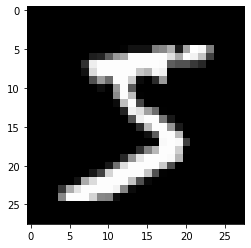

In [9]:
data_transform = Compose([ToTensor()])

train_data = MNIST(download=True, root="/tmp/mnist/", transform=data_transform, train=True)
val_data = MNIST(download=True, root="/tmp/mnist/", transform=data_transform, train=False)

image = train_data[0][0]
label = train_data[0][1]

print ('len(train_data) : ', len(train_data))
print ('len(val_data) : ', len(val_data))
print ('image.shape : ', image.shape)
print ('label : ', label)

img = plt.imshow(image.squeeze().numpy(), cmap='gray')

Now let's setup iterators of the training and validation datasets. We can take advantage of PyTorch's `DataLoader` that allows us to specify the dataset, batch size, number of workers, device, and other helpful parameters. 

Let's see what the output of the iterators are:
* We see that each batch consists of 32 images and their corresponding labels.
* Examples are shuffled.
* Data is placed on GPU if available, otherwise it uses CPU.

In [10]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True, **kwargs)

for batch in train_loader:
    x, y = batch
    break

print ('x.shape : ', x.shape)
print ('y.shape : ', y.shape)

x.shape :  torch.Size([32, 1, 28, 28])
y.shape :  torch.Size([32])


To visualize how well our model reconstruct images, let's save the above value of x as a set of images we can use to compare against the generation reconstructions from our model.

In [11]:
fixed_images = x.to(device)

## VAE Model

VAE is a model comprised of fully connected layers that take a flattened image, pass them through fully connected layers reducing the image to a low dimensional vector. The vector is then passed through a mirrored set of fully connected weights from the encoding steps, to generate a vector of the same size as the input.

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Creating Model, Optimizer and Loss

Below we create an instance of the VAE model. The model is placed on a device and then loss functions of Binary Cross Entropy + KL Divergence is used and Adam optimizer are setup. 

In [13]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def kld_loss(x_pred, x, mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

bce_loss = nn.BCELoss(reduction='sum')

## Training and Evaluating using Ignite

### Trainer Engine - process_function

Ignite's `Engine` allows user to define a `process_function` to process a given batch, this is applied to all the batches of the dataset. This is a general class that can be applied to train and validate models! A `process_function` has two parameters engine and batch. 


Let's walk through what the function of the trainer does:

* Sets model in train mode. 
* Sets the gradients of the optimizer to zero.
* Generate `x` from batch.
* Flattens `x` into shape `(-1, 784)`.
* Performs a forward pass to reconstuct `x` as `x_pred` using model and x. Model also return `mu`, `logvar`.
* Calculates loss using `x_pred`, `x`, `logvar` and `mu`.
* Performs a backward pass using loss to calculate gradients for the model parameters.
* model parameters are optimized using gradients and optimizer.
* Returns scalar loss. 

Below is a single operation during the trainig process. This process_function will be attached to the training engine.

In [14]:
def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, _ = batch
    x = x.to(device)
    x = x.view(-1, 784)
    x_pred, mu, logvar = model(x)
    BCE = bce_loss(x_pred, x)
    KLD = kld_loss(x_pred, x, mu, logvar)
    loss = BCE + KLD
    loss.backward()
    optimizer.step()
    return loss.item(), BCE.item(), KLD.item()

### Evaluator Engine - process_function

Similar to the training process function, we setup a function to evaluate a single batch. Here is what the `eval_function` does:

* Sets model in eval mode.
* Generates `x` from batch.
* With `torch.no_grad()`, no gradients are calculated for any succeding steps.
* Flattens `x` into shape `(-1, 784)`.
* Performs a forward pass to reconstuct `x` as `x_pred` using model and x. Model also return  `mu`, `logvar`.
* Returns `x_pred`, `x`, `mu` and `logvar`.

Ignite suggests attaching metrics to evaluators and not trainers because during the training the model parameters are constantly changing and it is best to evaluate model on a stationary model. This information is important as there is a difference in the functions for training and evaluating. Training returns a single scalar loss. Evaluating returns `y_pred` and `y` as that output is used to calculate metrics per batch for the entire dataset.

All metrics in `Ignite` require `y_pred` and `y` as outputs of the function attached to the `Engine`. 

In [15]:
def evaluate_function(engine, batch):
    model.eval()
    with torch.no_grad():
        x, _ = batch
        x = x.to(device)
        x = x.view(-1, 784)
        x_pred, mu, logvar = model(x)
        kwargs = {'mu': mu, 'logvar': logvar}
        return x_pred, x, kwargs

### Instantiating Training and Evaluating Engines

Below we create 2 engines, a `trainer` and `evaluator` using the functions defined above. We also define dictionaries to keep track of the history of the metrics on the training and validation sets. 

In [16]:
trainer = Engine(process_function)
evaluator = Engine(evaluate_function)
training_history = {'bce': [], 'kld': [], 'mse': []}
validation_history = {'bce': [], 'kld': [], 'mse': []}

### Metrics - RunningAverage, MeanSquareError and Loss

To start, we'll attach a metric of `RunningAverage` to track a running average of the scalar `loss`, `binary cross entropy` and `KL Divergence` output for each batch. 

In [17]:
RunningAverage(output_transform=lambda x: x[0]).attach(trainer, 'loss')
RunningAverage(output_transform=lambda x: x[1]).attach(trainer, 'bce')
RunningAverage(output_transform=lambda x: x[2]).attach(trainer, 'kld')

Now there are two metrics that we want to use for evaluation - `mean squared error`, `binary cross entropy` and `KL Divergence`. If you noticed earlier, out `eval_function` returns `x_pred`, `x` and a few other values, `MeanSquaredError` only expects two values per batch. 

For each batch, the `engine.state.output` will be `x_pred`, `x` and `kwargs`, this is why we use `output_transform` to only extract values from `engine.state.output` based on the the metric need.

As for `Loss`, we pass our defined `loss_function` and simply attach it to the `evaluator` as `engine.state.output` outputs all the parameters needed for `loss_function`.

In [18]:
MeanSquaredError(output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'mse')
Loss(bce_loss, output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'bce')
Loss(kld_loss).attach(evaluator, 'kld')

### Attaching Custom Functions to Engine at specific Events

Below you'll see ways to define your own custom functions and attaching them to various `Events` of the training process.

The first method involves using a decorator, the syntax is simple - `@` `trainer.on(Events.EPOCH_COMPLETED)`, means that the decorated function will be attached to the `trainer` and called at the end of each epoch. 

The second method involves using the `add_event_handler` method of `trainer` - `trainer.add_event_handler(Events.EPOCH_COMPLETED, custom_function)`. This achieves the same result as the above.


The function below print the loss during training at the end of each epoch. 

In [19]:
@trainer.on(Events.EPOCH_COMPLETED)
def print_trainer_logs(engine):
    avg_loss = engine.state.metrics['loss']
    avg_bce = engine.state.metrics['bce']
    avg_kld = engine.state.metrics['kld']
    print("Trainer Results - Epoch {} - Avg loss: {:.2f} Avg bce: {:.2f} Avg kld: {:.2f}"
          .format(engine.state.epoch, avg_loss, avg_bce, avg_kld))

The function below prints the logs of the `evaluator` and updates the history of metrics for training and validation datasets, we see that it takes parameters `DataLoader` and `mode`. Using this way we are repurposing a function and attaching it twice to the `trainer`, once to evaluate of the training dataset and other on the validation dataset.

In [20]:
def print_logs(engine, dataloader, mode, history_dict):
    evaluator.run(dataloader, max_epochs=1)
    metrics = evaluator.state.metrics
    avg_mse = metrics['mse']
    avg_bce = metrics['bce']
    avg_kld = metrics['kld']
    avg_loss =  avg_bce + avg_kld
    print(
        mode + " Results - Epoch {} - Avg mse: {:.2f} Avg loss: {:.2f} Avg bce: {:.2f} Avg kld: {:.2f}"
        .format(engine.state.epoch, avg_mse, avg_loss, avg_bce, avg_kld))
    for key in evaluator.state.metrics.keys():
        history_dict[key].append(evaluator.state.metrics[key])

trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, train_loader, 'Training', training_history)
trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, val_loader, 'Validation', validation_history)

The function below uses the set of images (`fixed_images`) and the VAE model to generate reconstructed images, the images are then formed into a grid, saved to your local machine and displayed in the notebook below. We attach this function to the start of the training process and at the end of each epoch, this way we'll be able to visualize how much better the model gets at reconstructing images. 

In [21]:
def compare_images(engine, save_img=False):
    epoch = engine.state.epoch
    reconstructed_images = model(fixed_images.view(-1, 784))[0].view(-1, 1, 28, 28)
    comparison = torch.cat([fixed_images, reconstructed_images])
    if save_img:
        save_image(comparison.detach().cpu(), 'reconstructed_epoch_' + str(epoch) + '.png', nrow=8)
    comparison_image = make_grid(comparison.detach().cpu(), nrow=8)
    fig = plt.figure(figsize=(5, 5));
    output = plt.imshow(comparison_image.permute(1, 2, 0));
    plt.title('Epoch ' + str(epoch));
    plt.show();

trainer.add_event_handler(Events.STARTED, compare_images, save_img=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compare_images, save_img=False)

### Run Engine

Next, we'll run the `trainer` for 10 epochs and monitor results.

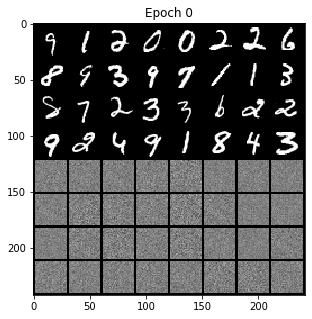

Trainer Results - Epoch 1 - Avg loss: 3709.79 Avg bce: 2959.32 Avg kld: 750.47
Training Results - Epoch 1 - Avg mse: 14.26 Avg loss: 3696.89 Avg bce: 2946.29 Avg kld: 750.59
Current run is terminating due to exception: .
Engine run is terminating due to exception: .
Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [22]:
e = trainer.run(train_loader, max_epochs=20)

### Plotting Results

Below we see plot the metrics collected on the training and validation sets. We plot the history of `Binary Cross Entropy`, `Mean Squared Error` and `KL Divergence`.

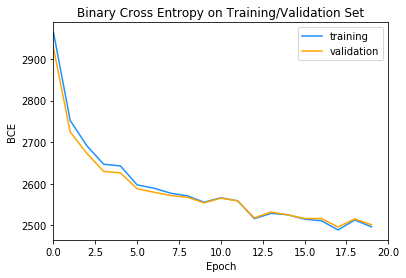

In [19]:
plt.plot(range(20), training_history['bce'], 'dodgerblue', label='training')
plt.plot(range(20), validation_history['bce'], 'orange', label='validation')
plt.xlim(0, 20);
plt.xlabel('Epoch')
plt.ylabel('BCE')
plt.title('Binary Cross Entropy on Training/Validation Set')
plt.legend();

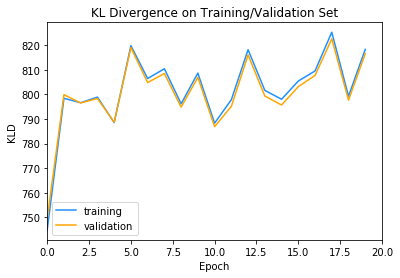

In [20]:
plt.plot(range(20), training_history['kld'], 'dodgerblue', label='training')
plt.plot(range(20), validation_history['kld'], 'orange', label='validation')
plt.xlim(0, 20);
plt.xlabel('Epoch')
plt.ylabel('KLD')
plt.title('KL Divergence on Training/Validation Set')
plt.legend();

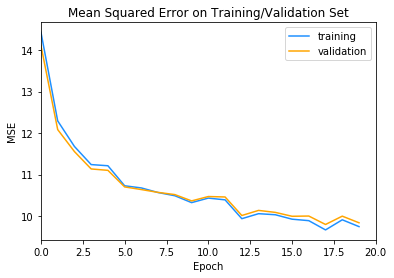

In [21]:
plt.plot(range(20), training_history['mse'], 'dodgerblue', label='training')
plt.plot(range(20), validation_history['mse'], 'orange', label='validation')
plt.xlim(0, 20);
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error on Training/Validation Set')
plt.legend();